In [2]:
import numpy as np
import gym
import random
import imageio
from tqdm.notebook import trange

In [5]:
env = gym.make("FrozenLake-v1",map_name="4x4",is_slippery=False)

print("Observation Space", env.observation_space)
print("Sample observation", env.observation_space.sample()) # display a random observation

Observation Space Discrete(16)
Sample observation 10


In [7]:
state_space = env.observation_space.n
print("There are ", state_space, " possible states")

action_space = env.action_space.n
print("There are ", action_space, " possible actions")

def initialize_q_table(state_space, action_space):
  Qtable = np.zeros((state_space, action_space))
  return Qtable

Qtable_frozenlake = initialize_q_table(state_space, action_space)

There are  16  possible states
There are  4  possible actions


In [8]:
def epsilon_greedy_policy(Qtable, state, epsilon):
  random_int = random.uniform(0,1)
  if random_int > epsilon:
    action = np.argmax(Qtable[state])
  else:
    action = env.action_space.sample()
  return action

In [9]:
def greedy_policy(Qtable, state):
  action = np.argmax(Qtable[state])
  return action

In [10]:
# Training parameters
n_training_episodes = 10000
learning_rate = 0.7        

# Evaluation parameters
n_eval_episodes = 100      

# Environment parameters
env_id = "FrozenLake-v1"   
max_steps = 99             
gamma = 0.95               
eval_seed = []             

# Exploration parameters
max_epsilon = 1.0           
min_epsilon = 0.05           
decay_rate = 0.0005           

In [11]:
def train(n_training_episodes, min_epsilon, max_epsilon, decay_rate, env, max_steps, Qtable):
  for episode in trange(n_training_episodes):
 
    epsilon = min_epsilon + (max_epsilon - min_epsilon)*np.exp(-decay_rate*episode)
    # Reset the environment
    state = env.reset()
    step = 0
    done = False

    # repeat
    for step in range(max_steps):
   
      action = epsilon_greedy_policy(Qtable, state, epsilon)

   
      new_state, reward, done, info = env.step(action)

   
      Qtable[state][action] = Qtable[state][action] + learning_rate * (reward + gamma * np.max(Qtable[new_state]) - Qtable[state][action])

      # If done, finish the episode
      if done:
        break
     
      # Our state is the new state
      state = new_state
  return Qtable

In [12]:
Qtable_frozenlake = train(n_training_episodes, min_epsilon, max_epsilon, decay_rate, env, max_steps, Qtable_frozenlake)

  0%|          | 0/10000 [00:00<?, ?it/s]

In [13]:
Qtable_frozenlake

array([[0.73509189, 0.77378094, 0.77378094, 0.73509189],
       [0.73509189, 0.        , 0.81450625, 0.77378094],
       [0.77378094, 0.857375  , 0.77378094, 0.81450625],
       [0.81450625, 0.        , 0.77378094, 0.77378094],
       [0.77378094, 0.81450625, 0.        , 0.73509189],
       [0.        , 0.        , 0.        , 0.        ],
       [0.        , 0.9025    , 0.        , 0.81450625],
       [0.        , 0.        , 0.        , 0.        ],
       [0.81450625, 0.        , 0.857375  , 0.77378094],
       [0.81450625, 0.9025    , 0.9025    , 0.        ],
       [0.857375  , 0.95      , 0.        , 0.857375  ],
       [0.        , 0.        , 0.        , 0.        ],
       [0.        , 0.        , 0.        , 0.        ],
       [0.        , 0.9025    , 0.95      , 0.857375  ],
       [0.9025    , 0.95      , 1.        , 0.9025    ],
       [0.        , 0.        , 0.        , 0.        ]])

In [14]:
def evaluate_agent(env, max_steps, n_eval_episodes, Q, seed):

  episode_rewards = []
  for episode in range(n_eval_episodes):
    if seed:
      state = env.reset(seed=seed[episode])
    else:
      state = env.reset()
    step = 0
    done = False
    total_rewards_ep = 0
   
    for step in range(max_steps):
      # Take the action (index) that have the maximum reward
      action = np.argmax(Q[state][:])
      new_state, reward, done, info = env.step(action)
      total_rewards_ep += reward
       
      if done:
        break
      state = new_state
    episode_rewards.append(total_rewards_ep)
  mean_reward = np.mean(episode_rewards)
  std_reward = np.std(episode_rewards)

  return mean_reward, std_reward

In [15]:
# Evaluate our Agent
mean_reward, std_reward = evaluate_agent(env, max_steps, n_eval_episodes, Qtable_frozenlake, eval_seed)
print(f"Mean_reward={mean_reward:.2f} +/- {std_reward:.2f}")

Mean_reward=1.00 +/- 0.00


In [19]:
def record_video(env, Qtable, out_directory, fps=1):
  images = [] 
  done = False
  state = env.reset(seed=random.randint(0,500))
  img = env.render(mode='rgb_array')
  images.append(img)
  while not done:
    # Take the action (index) that have the maximum expected future reward given that state
    action = np.argmax(Qtable[state][:])
    state, reward, done, info = env.step(action) # We directly put next_state = state for recording logic
    img = env.render(mode='rgb_array')
    images.append(img)
  imageio.mimsave(out_directory, [np.array(img) for i, img in enumerate(images)], fps=fps)

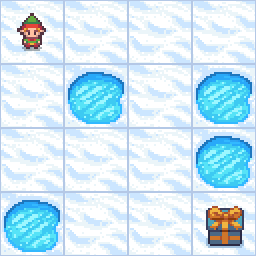

In [22]:
video_path="replay.gif"
video_fps=1
record_video(env, Qtable_frozenlake, video_path, video_fps)

from IPython.display import Image
Image('./replay.gif')